<h2>(1) Library</h2>

In [ ]:
!Pip install opencv

/bin/bash: Pip: command not found


In [ ]:
!pip install Keras-Preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import copy
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
import cv2
import keras
from keras import backend as K
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Flatten, Input
from keras.layers import Conv2D, Activation, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras_preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50
# from keras.applications.resnet50 import  ResNet50
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

<h2>(2) Constants</h2>

In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
from zipfile import ZipFile
with ZipFile('/content/gdrive/MyDrive/breastlow.zip','r') as zipobj:
  zipobj.extractall('BREAST')

In [ ]:
SEED = 42
DIR_PATH = "/content/BREAST/breastlow"
W = 112 # The default size for ResNet is 224 but resize to .5 to save memory size
H = 112 # The default size for ResNet is 224 but resize to .5 to save memory size
LABEL_TO_CLASS = {
    "augNlow": 0,
    "cancer":    1,

}
N_EPOCHS = 5
BATCH_SIZE = 32

In [ ]:
CLASS_TO_LABEL = {v: k for k, v in LABEL_TO_CLASS.items()}
N_CLASSES = len(LABEL_TO_CLASS)

<h2>(3) Functions</h2>

In [ ]:
def get_images(
        dir_path,
        label_to_class,
        w,
        h,
        seed,
    ):
    """Read images / labels from directory.

    Args:
        dir_path (str): Dir path saved data.
        label_to_class (dict[str, int]): Dict of label to class.
        w (int): Width size of image.
        h (int): Height size of image.
        seed (int): Random seed.

    Returns:
        tuple[np.ndarray, np.ndarray]: images, classes.
    """
    images = []
    classes = []

    for label_name in os.listdir(dir_path):
        cls = label_to_class[label_name]
        for img_name in os.listdir("/".join([dir_path, label_name])):
            img = load_img("/".join([dir_path, label_name, img_name]), target_size=(w, h))
            img = img_to_array(img)
            images.append(img)
            classes.append(cls)

    images = np.array(images, dtype=np.float32)
    classes = np.array(classes, dtype=np.float32)
    images, classes = shuffle(images, classes, random_state=seed)

    return images, classes


def split_dataset(
        images,
        classes,
        train_size=0.8,
        test_size=0.2,
        shuffle=False,
    ):
    """Split dataset.

    Args:
        images (np.ndarray): images.
        classes (np.ndarray): classes.
        train_size (float): Train data rate of split data.
        test_size (float): Test data rate of split data.
        shuffle (bool): Shuffle or not.

    Returns:
        tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]: X of train, y of train, X of test, y of test.
    """
    indices_train, indices_test = train_test_split(
        list(range(images.shape[0])),
        train_size=train_size,
        test_size=test_size,
        shuffle=shuffle,
    )

    x_train = images[indices_train]
    y_train = classes[indices_train]
    x_test = images[indices_test]
    y_test = classes[indices_test]

    return x_train, y_train, x_test, y_test


def build_model(w, h, n_classes):
    """Build model function.

    Args:
        w (int): Width size of image.
        h (int): Height size of image.
        n_classes (int): The number of class.

    Returns:
        keras.engine.training.Model: Model.
    """
    # Resnet
    input_tensor = Input(shape=(w, h, 3)) # To change input shape
    resnet50 = ResNet50(
        include_top=False,                # To change output shape
        weights="imagenet",               # Use pre-trained model
        input_tensor=input_tensor,        # Change input shape for this task
    )

    # fc layer
    top_model = Sequential()
    top_model.add(GlobalAveragePooling2D())               # Add GAP for cam
    top_model.add(Dense(n_classes, activation="softmax")) # Change output shape for this task

    # model
    model = Model(inputs=resnet50.input, outputs=top_model(resnet50.output))

    # frozen weights
    for layer in model.layers[:-10]:
        layer.trainable = False or isinstance(layer, BatchNormalization) # If Batch Normalization layer, it should be trainable

    # compile
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model


def superimpose(img, cam):
    """Superimpose original image and cam heatmap.

    Args:
        img (np.ndarray): Image.
        cam (np.ndarray): Cam image.

    Returns:
        tuple[np.ndarray, np.ndarray, np.ndarray]: Image, heatmap, superimposed image.
    """
    heatmap = cv2.resize(cam, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = heatmap * .5 + img * .5
    superimposed_img = np.minimum(superimposed_img, 255.0).astype(np.uint8) # scale 0 to 255
    superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

    return img, heatmap, superimposed_img



def grad_cam(model, x, layer_name):
    """Grad-CAM function.

    Args:
        model (keras.engine.training.Model): Model.
        x (np.ndarray): Input.
        layer_name (str): Get layer name

    Returns:
        tuple[int, np.ndarray]: Predicted class, heatmap of CAM.
    """
    cls = np.argmax(model.predict(x))

    y_c = model.output[0, cls]
    conv_output = model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]

    # Get outputs and grads
    gradient_function = K.function([model.input], [conv_output, grads])
    output, grads_val = gradient_function([x])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis=(0, 1)) # Passing through GlobalAveragePooling

    cam = np.dot(output, weights) # multiply
    cam = np.maximum(cam, 0)      # Passing through ReLU
    cam /= np.max(cam)            # scale 0 to 1.0

    return cls, cam


def grad_cam_plus_plus(model, x, layer_name):
    """Grad-CAM++ function.

    Args:
        model (keras.engine.training.Model): Model.
        x (np.ndarray): Input.
        layer_name (str): Get layer name.

    Returns:
        tuple[int, np.ndarray]: Predicted class, heatmap of CAM.
    """
    cls = np.argmax(model.predict(x))
    y_c = model.output[0, cls]
    conv_output = model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]

    # first / second / third derivative
    first = K.exp(y_c) * grads
    second = K.exp(y_c) * grads * grads
    third = K.exp(y_c) * grads * grads * grads

    # Get outputs, grads and higher order derivatives
    gradient_function = K.function([model.input], [y_c, first, second, third, conv_output, grads])
    y_c, conv_first_grad, conv_second_grad, conv_third_grad, conv_output, grads_val = gradient_function([x])

    # Calculate weight alpha
    global_sum = np.sum(conv_output[0].reshape((-1,conv_first_grad[0].shape[2])), axis=0)
    alpha_num = conv_second_grad[0]
    alpha_denom = conv_second_grad[0] * 2.0 + conv_third_grad[0] * global_sum.reshape((1, 1, conv_first_grad[0].shape[2]))
    alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, np.ones(alpha_denom.shape))
    alphas = alpha_num / alpha_denom

    weights = np.maximum(conv_first_grad[0], 0.0)
    alpha_normalization_constant = np.sum(np.sum(alphas, axis=0), axis=0)
    alphas /= alpha_normalization_constant.reshape((1, 1, conv_first_grad[0].shape[2]))
    deep_linearization_weights = np.sum((weights * alphas).reshape((-1, conv_first_grad[0].shape[2])), axis=0)

    cam = np.sum(deep_linearization_weights * conv_output[0], axis=2) # multiply
    cam = np.maximum(cam, 0)                                          # Passing through ReLU
    cam /= np.max(cam)                                                # scale 0 to 1.0

    return cls, cam


def softmax(x):
    """Softmax function.

    Args:
        x (np.ndarray): Input.

    Returns:
        np.ndarray: Softmax(x)
    """
    return np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)


def compare_each_cam(
        images,
        classes,
        class_to_label,
        model,
        grad_cam,
        grad_cam_plus_plus,
        score_cam,
        superimpose,
        layer_name,
        target_cls,
    ):

    indices = np.where(classes == target_cls)[0]
    label = class_to_label[target_cls]

    n_cols = 10 # # of sample plot

    fig, axs = plt.subplots(ncols=n_cols, nrows=4, figsize=(25, 9))

    for i in range(n_cols):

        img = images[indices[i]]

        # for cam
        x = np.expand_dims(img, axis=0)
        x = preprocess_input(copy.deepcopy(x))

        # original
        axs[0, i].imshow(np.uint8(img))
        axs[0, i].set_title(label)
        axs[0, i].set_xticks([])
        axs[0, i].set_yticks([])
        if i == 0:
            axs[0, i].set_ylabel("Original", rotation=0, ha="right")

        # Grad-CAM
        cls_pred, cam = grad_cam(model=model, x=x, layer_name=layer_name)
        _, _, img_grad_cam = superimpose(img, cam)
        axs[1, i].imshow(img_grad_cam)
        axs[1, i].set_title("pred: " + class_to_label[cls_pred])
        axs[1, i].set_xticks([])
        axs[1, i].set_yticks([])
        if i == 0:
            axs[1, i].set_ylabel("Grad-CAM", rotation=0, ha="right")

        # Grad-CAM++
        cls_pred, cam = grad_cam_plus_plus(model=model, x=x, layer_name=layer_name)
        _, _, img_grad_cam_plus_plus = superimpose(img, cam)
        axs[2, i].imshow(img_grad_cam_plus_plus)
        axs[2, i].set_title("pred: " + class_to_label[cls_pred])
        axs[2, i].set_xticks([])
        axs[2, i].set_yticks([])
        if i == 0:
            axs[2, i].set_ylabel("Grad-CAM++", rotation=0, ha="right")

    plt.show()

<h2>(4) Prepare data</h2>

In [ ]:
images, classes = get_images(
    dir_path=DIR_PATH,
    label_to_class=LABEL_TO_CLASS,
    w=W,
    h=H,
    seed=SEED,
)

images.shape, classes.shape

((4032, 112, 112, 3), (4032,))

In [ ]:
# Check the number of images for each labels

n_total_images = images.shape[0]
for target_cls in list(CLASS_TO_LABEL.keys()):
    indices = np.where(classes == target_cls)[0] # get target class indices on images / classes
    n_target_cls = indices.shape[0]
    label = CLASS_TO_LABEL[target_cls]
    print(label, ":", n_target_cls, round(n_target_cls / n_total_images, 2))

augNlow : 2046 0.51
cancer : 1986 0.49


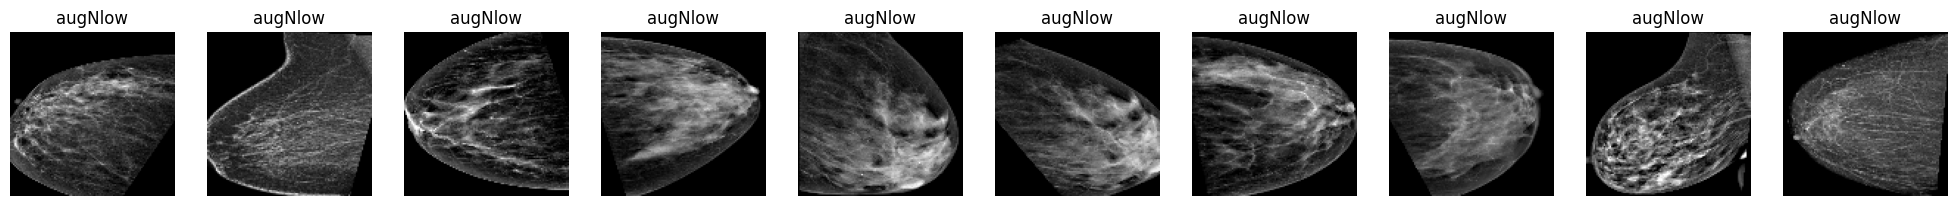

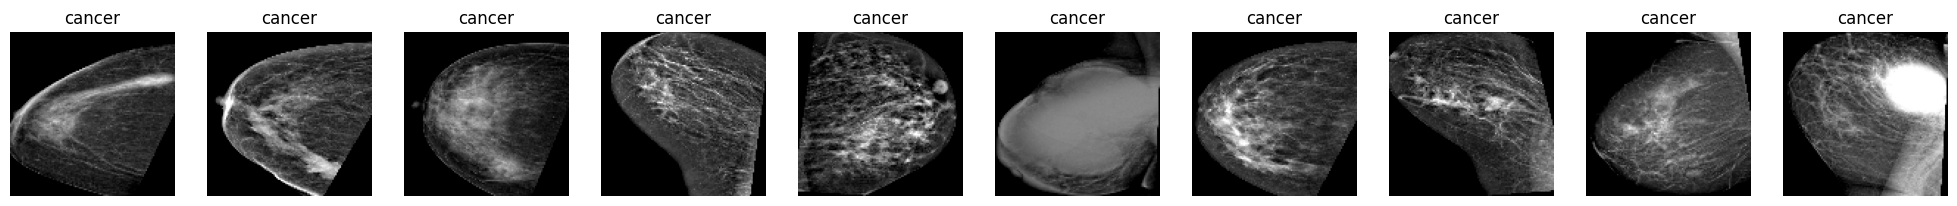

In [ ]:
# Visualize some images / labels

for target_cls in list(CLASS_TO_LABEL.keys()):
    indices = np.where(classes == target_cls)[0] # get target class indices on images / classes
    label = CLASS_TO_LABEL[target_cls]

    n_cols = 10 # The number of sample plot
    fig, axs = plt.subplots(ncols=n_cols, figsize=(25, 3))

    for i in range(n_cols):
        axs[i].imshow(np.uint8(images[indices[i]]))
        axs[i].axis('off')
        axs[i].set_title(label)

    plt.show()

<h2> (5) Preprocess for train</h2>

In [ ]:
# split dataset to train and test

x_train, y_train, x_test, y_test = split_dataset(images, classes)

# to one-hot

y_train = keras.utils.to_categorical(y_train, N_CLASSES)
y_test = keras.utils.to_categorical(y_test, N_CLASSES)

# To image data generator
# Use image data augmentation for train data

datagen_train = ImageDataGenerator(
    preprocessing_function=preprocess_input, # image preprocessing function
    rotation_range=30,                       # randomly rotate images in the range
    zoom_range=0.1,                          # Randomly zoom image
    width_shift_range=0.1,                   # randomly shift images horizontally
    height_shift_range=0.1,                  # randomly shift images vertically
    horizontal_flip=True,                    # randomly flip images horizontally
    vertical_flip=False,                     # randomly flip images vertically
)
datagen_test = ImageDataGenerator(
    preprocessing_function=preprocess_input, # image preprocessing function
)

<h2>(6) Prepare the model</h2>

In [ ]:
model = build_model(w=W, h=H, n_classes=N_CLASSES)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 112, 112, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 118, 118, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 56, 56, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 56, 56, 64)   256         ['conv1_conv[0][0]']       

<h2>(7) Finetuning the model</h2>

In [ ]:
history = model.fit_generator(
    datagen_train.flow(
        x_train,
        y_train,
        batch_size=BATCH_SIZE,
    ),
    epochs=N_EPOCHS,
    validation_data=datagen_test.flow(
        x_test,
        y_test,
        batch_size=BATCH_SIZE,
    ),
)

Epoch 1/5
101/101 [==============================] - 35s 217ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.8448 - accuracy: 0.5991 - val_loss: 1.1242 - val_accuracy: 0.5366
Epoch 2/5
101/101 [==============================] - 20s 200ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.6054 - accuracy: 0.6704 - val_loss: 0.6939 - val_accuracy: 0.6729
Epoch 3/5
101/101 [==============================] - 20s 202ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.5936 - accuracy: 0.6843 - val_loss: 0.6795 - val_accuracy: 0.6555
Epoch 4/5
101/101 [==============================] - 20s 197ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.5695 - accuracy: 0.6980 - val_loss: 0.7433 - val_accuracy: 0.6518
Epoch 5/5
101/101 [==============================] - 21s 209ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.5451 - accuracy: 0.7188 - val_loss: 0.6650 - val_accuracy: 0.6791


In [ ]:
model.save_weights('/content/gdrive/MyDrive/weights/grad1.h5')

In [ ]:
model.load_weights('/content/gdrive/MyDrive/weights/grad1.h5')

In [ ]:
history = model.fit_generator(
    datagen_train.flow(
        x_train,
        y_train,
        batch_size=BATCH_SIZE,
    ),
    epochs=N_EPOCHS,
    validation_data=datagen_test.flow(
        x_test,
        y_test,
        batch_size=BATCH_SIZE,
    ),
)

Epoch 1/5
101/101 [==============================] - 31s 311ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.5214 - accuracy: 0.7498 - val_loss: 0.6538 - val_accuracy: 0.6853
Epoch 2/5
101/101 [==============================] - 23s 226ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.4960 - accuracy: 0.7560 - val_loss: 0.6255 - val_accuracy: 0.7038
Epoch 3/5
101/101 [==============================] - 20s 198ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.4951 - accuracy: 0.7643 - val_loss: 0.8561 - val_accuracy: 0.6543
Epoch 4/5
101/101 [==============================] - 23s 223ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.4687 - accuracy: 0.7705 - val_loss: 0.5676 - val_accuracy: 0.7237
Epoch 5/5
101/101 [==============================] - 19s 193ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.4542 - accuracy: 0.7842 - val_loss: 0.5259 - val_accuracy: 0.7361


In [ ]:
model.save_weights('/content/gdrive/MyDrive/weights/grad2.h5')

In [ ]:
model.load_weights('/content/gdrive/MyDrive/weights/grad2.h5')

In [ ]:
history = model.fit_generator(
    datagen_train.flow(
        x_train,
        y_train,
        batch_size=BATCH_SIZE,
    ),
    epochs=N_EPOCHS,
    validation_data=datagen_test.flow(
        x_test,
        y_test,
        batch_size=BATCH_SIZE,
    ),
)

Epoch 1/5
101/101 [==============================] - 22s 220ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.4310 - accuracy: 0.7991 - val_loss: 0.6445 - val_accuracy: 0.7063
Epoch 2/5
101/101 [==============================] - 20s 194ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.4071 - accuracy: 0.8068 - val_loss: 0.5711 - val_accuracy: 0.7373
Epoch 3/5
101/101 [==============================] - 21s 207ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.4101 - accuracy: 0.8121 - val_loss: 0.5446 - val_accuracy: 0.7423
Epoch 4/5
101/101 [==============================] - 20s 196ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.3860 - accuracy: 0.8233 - val_loss: 0.7226 - val_accuracy: 0.7051
Epoch 5/5
101/101 [==============================] - 21s 204ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.3648 - accuracy: 0.8322 - val_loss: 0.7489 - val_accuracy: 0.7026


In [ ]:
model.save_weights('/content/gdrive/MyDrive/weights/grad20.h5')

In [ ]:
model.load_weights('/content/gdrive/MyDrive/weights/grad20.h5')

In [ ]:
history = model.fit_generator(
    datagen_train.flow(
        x_train,
        y_train,
        batch_size=BATCH_SIZE,
    ),
    epochs=N_EPOCHS,
    validation_data=datagen_test.flow(
        x_test,
        y_test,
        batch_size=BATCH_SIZE,
    ),
)

Epoch 1/5
101/101 [==============================] - 21s 202ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.3560 - accuracy: 0.8478 - val_loss: 0.5014 - val_accuracy: 0.7807
Epoch 2/5
101/101 [==============================] - 21s 212ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.3332 - accuracy: 0.8484 - val_loss: 0.6525 - val_accuracy: 0.7472
Epoch 3/5
101/101 [==============================] - 20s 203ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.3103 - accuracy: 0.8608 - val_loss: 0.7076 - val_accuracy: 0.7398
Epoch 4/5
101/101 [==============================] - 22s 217ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.2881 - accuracy: 0.8809 - val_loss: 0.8231 - val_accuracy: 0.7187
Epoch 5/5
101/101 [==============================] - 20s 200ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.2822 - accuracy: 0.8788 - val_loss: 0.6651 - val_accuracy: 0.7546


In [ ]:
model.save_weights('/content/gdrive/MyDrive/weights/grad3.h5')

In [ ]:
model.load_weights('/content/gdrive/MyDrive/weights/grad3.h5')

In [ ]:
history = model.fit_generator(
    datagen_train.flow(
        x_train,
        y_train,
        batch_size=BATCH_SIZE,
    ),
    epochs=N_EPOCHS,
    validation_data=datagen_test.flow(
        x_test,
        y_test,
        batch_size=BATCH_SIZE,
    ),
)

Epoch 1/5
101/101 [==============================] - 23s 228ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.2690 - accuracy: 0.8868 - val_loss: 0.5805 - val_accuracy: 0.7683
Epoch 2/5
101/101 [==============================] - 20s 200ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.2616 - accuracy: 0.8893 - val_loss: 0.6260 - val_accuracy: 0.7621
Epoch 3/5
101/101 [==============================] - 21s 212ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.2623 - accuracy: 0.8905 - val_loss: 1.0027 - val_accuracy: 0.7100
Epoch 4/5
101/101 [==============================] - 20s 196ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.2422 - accuracy: 0.8974 - val_loss: 0.6253 - val_accuracy: 0.7720
Epoch 5/5
101/101 [==============================] - 21s 213ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.2296 - accuracy: 0.9033 - val_loss: 0.6446 - val_accuracy: 0.7782


In [ ]:
model.save_weights('/content/gdrive/MyDrive/weights/grad4.h5')

In [ ]:
model.load_weights('/content/gdrive/MyDrive/weights/grad4.h5')

In [ ]:
history = model.fit_generator(
    datagen_train.flow(
        x_train,
        y_train,
        batch_size=BATCH_SIZE,
    ),
    epochs=N_EPOCHS,
    validation_data=datagen_test.flow(
        x_test,
        y_test,
        batch_size=BATCH_SIZE,
    ),
)

Epoch 1/5
101/101 [==============================] - 21s 212ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.2306 - accuracy: 0.8992 - val_loss: 0.5793 - val_accuracy: 0.7819
Epoch 2/5
101/101 [==============================] - 22s 216ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.2162 - accuracy: 0.9169 - val_loss: 0.5549 - val_accuracy: 0.7968
Epoch 3/5
101/101 [==============================] - 20s 197ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.2013 - accuracy: 0.9166 - val_loss: 0.7950 - val_accuracy: 0.7720
Epoch 4/5
101/101 [==============================] - 21s 208ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.1924 - accuracy: 0.9197 - val_loss: 0.5493 - val_accuracy: 0.8092
Epoch 5/5
101/101 [==============================] - 20s 194ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.1772 - accuracy: 0.9250 - val_loss: 0.5198 - val_accuracy: 0.8116


In [ ]:
model.save_weights('/content/gdrive/MyDrive/weights/grad5.h5')

In [ ]:
model.load_weights('/content/gdrive/MyDrive/weights/grad5.h5')

In [ ]:
history = model.fit_generator(
    datagen_train.flow(
        x_train,
        y_train,
        batch_size=BATCH_SIZE,
    ),
    epochs=N_EPOCHS,
    validation_data=datagen_test.flow(
        x_test,
        y_test,
        batch_size=BATCH_SIZE,
    ),
)

Epoch 1/5
101/101 [==============================] - 21s 209ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.1926 - accuracy: 0.9250 - val_loss: 0.4630 - val_accuracy: 0.8377
Epoch 2/5
101/101 [==============================] - 20s 194ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.1532 - accuracy: 0.9417 - val_loss: 0.8140 - val_accuracy: 0.7782
Epoch 3/5
101/101 [==============================] - 21s 208ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.1563 - accuracy: 0.9367 - val_loss: 0.8467 - val_accuracy: 0.7695
Epoch 4/5
101/101 [==============================] - 20s 194ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.1533 - accuracy: 0.9414 - val_loss: 1.5127 - val_accuracy: 0.6803
Epoch 5/5
101/101 [==============================] - 21s 210ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.1443 - accuracy: 0.9420 - val_loss: 0.8637 - val_accuracy: 0.7869


In [ ]:
model.save_weights('/content/gdrive/MyDrive/weights/grad6.h5')

In [ ]:
model.load_weights('/content/gdrive/MyDrive/weights/grad6.h5')

In [ ]:
history = model.fit_generator(
    datagen_train.flow(
        x_train,
        y_train,
        batch_size=BATCH_SIZE,
    ),
    epochs=N_EPOCHS,
    validation_data=datagen_test.flow(
        x_test,
        y_test,
        batch_size=BATCH_SIZE,
    ),
)

Epoch 1/5
101/101 [==============================] - 20s 200ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.1368 - accuracy: 0.9460 - val_loss: 0.8162 - val_accuracy: 0.7869
Epoch 2/5
101/101 [==============================] - 21s 209ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.1453 - accuracy: 0.9383 - val_loss: 0.5715 - val_accuracy: 0.8327
Epoch 3/5
101/101 [==============================] - 20s 196ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.1330 - accuracy: 0.9507 - val_loss: 0.6253 - val_accuracy: 0.8253
Epoch 4/5
101/101 [==============================] - 21s 209ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.1284 - accuracy: 0.9498 - val_loss: 0.7664 - val_accuracy: 0.7943
Epoch 5/5
101/101 [==============================] - 19s 193ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.1135 - accuracy: 0.9563 - val_loss: 0.5522 - val_accuracy: 0.8414


In [ ]:
model.save_weights('/content/gdrive/MyDrive/weights/grad7.h5')

In [ ]:
model.load_weights('/content/gdrive/MyDrive/weights/grad7.h5')

In [ ]:
history = model.fit_generator(
    datagen_train.flow(
        x_train,
        y_train,
        batch_size=BATCH_SIZE,
    ),
    epochs=N_EPOCHS,
    validation_data=datagen_test.flow(
        x_test,
        y_test,
        batch_size=BATCH_SIZE,
    ),
)

Epoch 1/5
101/101 [==============================] - 22s 217ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.1042 - accuracy: 0.9566 - val_loss: 0.5301 - val_accuracy: 0.8340
Epoch 2/5
101/101 [==============================] - 19s 193ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.1250 - accuracy: 0.9529 - val_loss: 0.5865 - val_accuracy: 0.8265
Epoch 3/5
101/101 [==============================] - 21s 209ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.1110 - accuracy: 0.9566 - val_loss: 0.6853 - val_accuracy: 0.8092
Epoch 4/5
101/101 [==============================] - 19s 193ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.1177 - accuracy: 0.9526 - val_loss: 0.4627 - val_accuracy: 0.8451
Epoch 5/5
101/101 [==============================] - 21s 210ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.1157 - accuracy: 0.9566 - val_loss: 0.4457 - val_accuracy: 0.8600


In [ ]:
model.save_weights('/content/gdrive/MyDrive/weights/grad8.h5')

In [ ]:
model.load_weights('/content/gdrive/MyDrive/weights/grad8.h5')

In [ ]:
history = model.fit_generator(
    datagen_train.flow(
        x_train,
        y_train,
        batch_size=BATCH_SIZE,
    ),
    epochs=N_EPOCHS,
    validation_data=datagen_test.flow(
        x_test,
        y_test,
        batch_size=BATCH_SIZE,
    ),
)

Epoch 1/5
101/101 [==============================] - 20s 200ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.0985 - accuracy: 0.9671 - val_loss: 0.6713 - val_accuracy: 0.8253
Epoch 2/5
101/101 [==============================] - 21s 209ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.0729 - accuracy: 0.9730 - val_loss: 0.5170 - val_accuracy: 0.8587
Epoch 3/5
101/101 [==============================] - 19s 193ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.0904 - accuracy: 0.9671 - val_loss: 0.6358 - val_accuracy: 0.8141
Epoch 4/5
101/101 [==============================] - 21s 209ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.1053 - accuracy: 0.9597 - val_loss: 0.5729 - val_accuracy: 0.8414
Epoch 5/5
101/101 [==============================] - 19s 191ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.0757 - accuracy: 0.9721 - val_loss: 0.4823 - val_accuracy: 0.8612


In [ ]:
model.save_weights('/content/gdrive/MyDrive/weights/grad9.h5')

In [ ]:
model.load_weights('/content/gdrive/MyDrive/weights/grad9.h5')

In [ ]:
history = model.fit_generator(
    datagen_train.flow(
        x_train,
        y_train,
        batch_size=BATCH_SIZE,
    ),
    epochs=N_EPOCHS,
    validation_data=datagen_test.flow(
        x_test,
        y_test,
        batch_size=BATCH_SIZE,
    ),
)

Epoch 1/5
101/101 [==============================] - 22s 217ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.0938 - accuracy: 0.9631 - val_loss: 0.4881 - val_accuracy: 0.8649
Epoch 2/5
101/101 [==============================] - 19s 193ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.0919 - accuracy: 0.9662 - val_loss: 0.4734 - val_accuracy: 0.8674
Epoch 3/5
101/101 [==============================] - 21s 209ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.0883 - accuracy: 0.9668 - val_loss: 0.6830 - val_accuracy: 0.8116
Epoch 4/5
101/101 [==============================] - 19s 191ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.0852 - accuracy: 0.9699 - val_loss: 0.6852 - val_accuracy: 0.8191
Epoch 5/5
101/101 [==============================] - 21s 209ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.0857 - accuracy: 0.9684 - val_loss: 0.4284 - val_accuracy: 0.8748


In [ ]:
model.save_weights('/content/gdrive/MyDrive/weights/grad9.h5')

In [ ]:
model.load_weights('/content/gdrive/MyDrive/weights/grad9.h5')

In [ ]:
history = model.fit_generator(
    datagen_train.flow(
        x_train,
        y_train,
        batch_size=BATCH_SIZE,
    ),
    epochs=N_EPOCHS,
    validation_data=datagen_test.flow(
        x_test,
        y_test,
        batch_size=BATCH_SIZE,
    ),
)

Epoch 1/5
101/101 [==============================] - 20s 201ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.0806 - accuracy: 0.9681 - val_loss: 0.4218 - val_accuracy: 0.8798
Epoch 2/5
101/101 [==============================] - 21s 212ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.0743 - accuracy: 0.9733 - val_loss: 0.7967 - val_accuracy: 0.7931
Epoch 3/5
101/101 [==============================] - 19s 191ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.0625 - accuracy: 0.9777 - val_loss: 0.5055 - val_accuracy: 0.8525
Epoch 4/5
101/101 [==============================] - 22s 218ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.0696 - accuracy: 0.9733 - val_loss: 0.5923 - val_accuracy: 0.8451
Epoch 5/5
101/101 [==============================] - 20s 194ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.0720 - accuracy: 0.9736 - val_loss: 0.7225 - val_accuracy: 0.8327


In [ ]:
model.save_weights('/content/gdrive/MyDrive/weights/grad10.h5')

In [ ]:
model.load_weights('/content/gdrive/MyDrive/weights/grad10.h5')

In [ ]:
history = model.fit_generator(
    datagen_train.flow(
        x_train,
        y_train,
        batch_size=BATCH_SIZE,
    ),
    epochs=N_EPOCHS,
    validation_data=datagen_test.flow(
        x_test,
        y_test,
        batch_size=BATCH_SIZE,
    ),
)

Epoch 1/5
101/101 [==============================] - 22s 216ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.0711 - accuracy: 0.9740 - val_loss: 0.4242 - val_accuracy: 0.8686
Epoch 2/5
101/101 [==============================] - 19s 190ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.0681 - accuracy: 0.9733 - val_loss: 0.5622 - val_accuracy: 0.8525
Epoch 3/5
101/101 [==============================] - 21s 206ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.0518 - accuracy: 0.9805 - val_loss: 0.5726 - val_accuracy: 0.8550
Epoch 4/5
101/101 [==============================] - 20s 195ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.0836 - accuracy: 0.9690 - val_loss: 0.6007 - val_accuracy: 0.8451
Epoch 5/5
101/101 [==============================] - 20s 203ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.0572 - accuracy: 0.9789 - val_loss: 0.6120 - val_accuracy: 0.8488


In [ ]:
model.save_weights('/content/gdrive/MyDrive/weights/grad11.h5')

In [ ]:
model.load_weights('/content/gdrive/MyDrive/weights/grad11.h5')

In [ ]:
history = model.fit_generator(
    datagen_train.flow(
        x_train,
        y_train,
        batch_size=BATCH_SIZE,
    ),
    epochs=N_EPOCHS,
    validation_data=datagen_test.flow(
        x_test,
        y_test,
        batch_size=BATCH_SIZE,
    ),
)

Epoch 1/5
101/101 [==============================] - 20s 196ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.0618 - accuracy: 0.9774 - val_loss: 1.0540 - val_accuracy: 0.7831
Epoch 2/5
101/101 [==============================] - 21s 204ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.0702 - accuracy: 0.9758 - val_loss: 0.6119 - val_accuracy: 0.8501
Epoch 3/5
101/101 [==============================] - 19s 190ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.0600 - accuracy: 0.9774 - val_loss: 0.5703 - val_accuracy: 0.8649
Epoch 4/5
101/101 [==============================] - 19s 191ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.0570 - accuracy: 0.9798 - val_loss: 0.7451 - val_accuracy: 0.8290
Epoch 5/5
101/101 [==============================] - 21s 204ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.0496 - accuracy: 0.9805 - val_loss: 0.8776 - val_accuracy: 0.7955


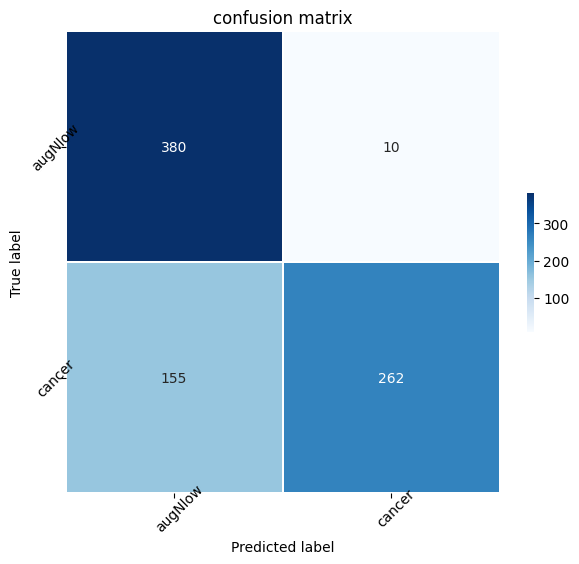

In [ ]:
# Confirm the result of finetuning
# Plot the confusion matrix

plot_confusion_matrix(model, x_test, LABEL_TO_CLASS)

<h2>(8) Implement Grad-CAM, Grad-CAM++ and Score CAM</h2>

In [ ]:
model.save_weights('/content/gdrive/MyDrive/weights/grad12.h5')

In [ ]:
model.load_weights('/content/gdrive/MyDrive/weights/grad12.h5')

In [ ]:
history = model.fit_generator(
    datagen_train.flow(
        x_train,
        y_train,
        batch_size=BATCH_SIZE,
    ),
    epochs=N_EPOCHS,
    validation_data=datagen_test.flow(
        x_test,
        y_test,
        batch_size=BATCH_SIZE,
    ),
)

Epoch 1/5
101/101 [==============================] - 22s 213ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.0593 - accuracy: 0.9777 - val_loss: 0.4753 - val_accuracy: 0.8823
Epoch 2/5
101/101 [==============================] - 19s 193ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.0524 - accuracy: 0.9798 - val_loss: 0.4343 - val_accuracy: 0.8810
Epoch 3/5
101/101 [==============================] - 20s 202ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.0542 - accuracy: 0.9792 - val_loss: 0.5520 - val_accuracy: 0.8525
Epoch 4/5
101/101 [==============================] - 20s 194ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.0419 - accuracy: 0.9851 - val_loss: 0.5056 - val_accuracy: 0.8575
Epoch 5/5
101/101 [==============================] - 19s 193ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.0589 - accuracy: 0.9767 - val_loss: 0.4216 - val_accuracy: 0.8848


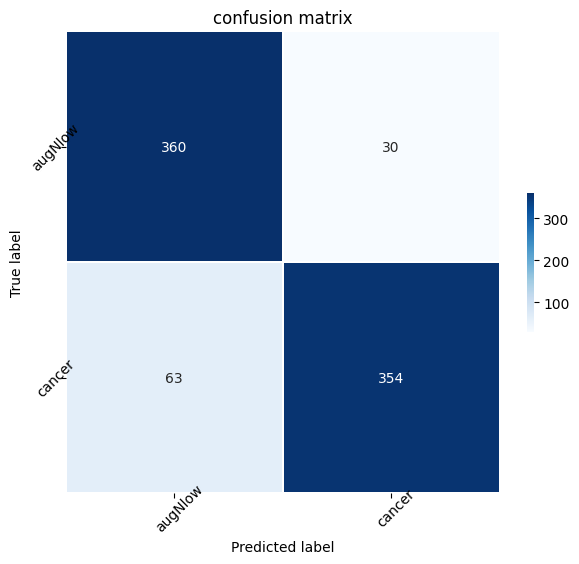

In [ ]:
# Confirm the result of finetuning
# Plot the confusion matrix

plot_confusion_matrix(model, x_test, LABEL_TO_CLASS)

In [ ]:
model.save_weights('/content/gdrive/MyDrive/weights/grad13.h5')

In [ ]:
model.load_weights('/content/gdrive/MyDrive/weights/grad13.h5')

In [ ]:
history = model.fit_generator(
    datagen_train.flow(
        x_train,
        y_train,
        batch_size=BATCH_SIZE,
    ),
    epochs=N_EPOCHS,
    validation_data=datagen_test.flow(
        x_test,
        y_test,
        batch_size=BATCH_SIZE,
    ),
)

Epoch 1/5
101/101 [==============================] - 21s 202ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.0443 - accuracy: 0.9826 - val_loss: 0.5596 - val_accuracy: 0.8575
Epoch 2/5
101/101 [==============================] - 19s 191ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.0530 - accuracy: 0.9820 - val_loss: 0.4440 - val_accuracy: 0.8848
Epoch 3/5
101/101 [==============================] - 20s 201ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.0512 - accuracy: 0.9820 - val_loss: 0.5362 - val_accuracy: 0.8711
Epoch 4/5
101/101 [==============================] - 19s 190ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.0556 - accuracy: 0.9811 - val_loss: 0.5378 - val_accuracy: 0.8612
Epoch 5/5
101/101 [==============================] - 21s 210ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.0542 - accuracy: 0.9805 - val_loss: 0.6286 - val_accuracy: 0.8550


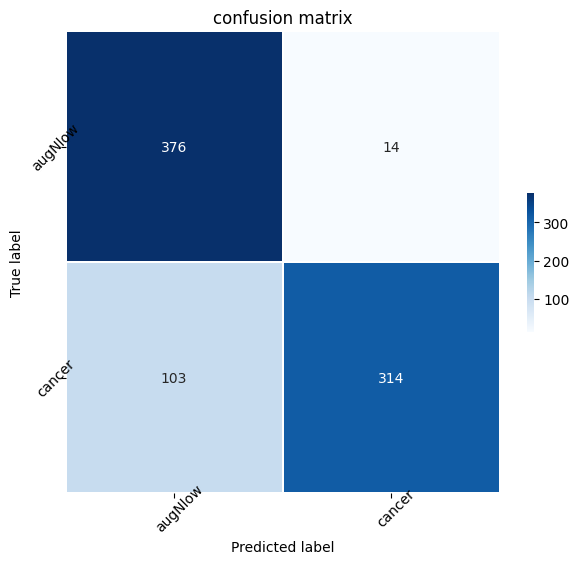

In [ ]:
# Confirm the result of finetuning
# Plot the confusion matrix

plot_confusion_matrix(model, x_test, LABEL_TO_CLASS)

In [ ]:
model.save_weights('/content/gdrive/MyDrive/weights/grad14.h5')

In [ ]:
model.load_weights('/content/gdrive/MyDrive/weights/grad14.h5')

In [ ]:
history = model.fit_generator(
    datagen_train.flow(
        x_train,
        y_train,
        batch_size=BATCH_SIZE,
    ),
    epochs=N_EPOCHS,
    validation_data=datagen_test.flow(
        x_test,
        y_test,
        batch_size=BATCH_SIZE,
    ),
)

Epoch 1/5
101/101 [==============================] - 21s 204ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.0556 - accuracy: 0.9798 - val_loss: 0.5005 - val_accuracy: 0.8724
Epoch 2/5
101/101 [==============================] - 20s 200ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.0359 - accuracy: 0.9870 - val_loss: 0.4813 - val_accuracy: 0.8736
Epoch 3/5
101/101 [==============================] - 19s 190ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.0362 - accuracy: 0.9839 - val_loss: 0.6788 - val_accuracy: 0.8625
Epoch 4/5
101/101 [==============================] - 21s 209ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.0392 - accuracy: 0.9833 - val_loss: 0.4654 - val_accuracy: 0.8872
Epoch 5/5
101/101 [==============================] - 20s 193ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.0481 - accuracy: 0.9811 - val_loss: 0.6652 - val_accuracy: 0.8538


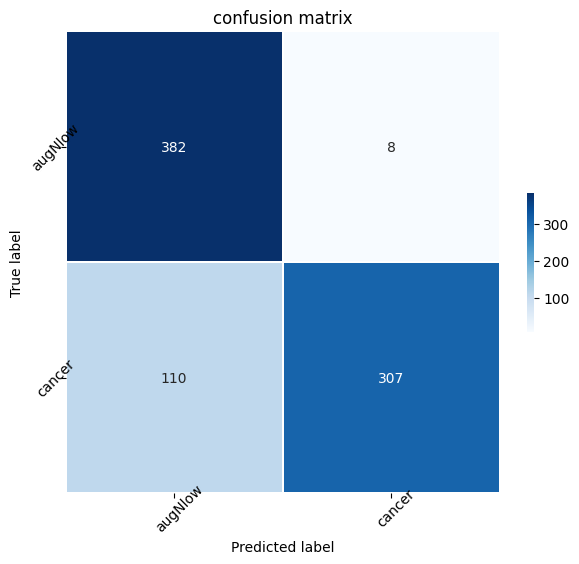

In [ ]:
# Confirm the result of finetuning
# Plot the confusion matrix

plot_confusion_matrix(model, x_test, LABEL_TO_CLASS)

In [ ]:
model.save_weights('/content/gdrive/MyDrive/weights/grad15.h5')

In [ ]:
model.load_weights('/content/gdrive/MyDrive/weights/grad15.h5')

In [ ]:
history = model.fit_generator(
    datagen_train.flow(
        x_train,
        y_train,
        batch_size=BATCH_SIZE,
    ),
    epochs=N_EPOCHS,
    validation_data=datagen_test.flow(
        x_test,
        y_test,
        batch_size=BATCH_SIZE,
    ),
)

Epoch 1/5
101/101 [==============================] - 22s 220ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.0363 - accuracy: 0.9885 - val_loss: 0.5156 - val_accuracy: 0.8810
Epoch 2/5
101/101 [==============================] - 21s 209ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.0396 - accuracy: 0.9839 - val_loss: 0.9196 - val_accuracy: 0.8253
Epoch 3/5
101/101 [==============================] - 21s 210ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.0368 - accuracy: 0.9854 - val_loss: 0.5006 - val_accuracy: 0.8835
Epoch 4/5
101/101 [==============================] - 24s 236ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.0458 - accuracy: 0.9829 - val_loss: 0.5502 - val_accuracy: 0.8736
Epoch 5/5
101/101 [==============================] - 20s 202ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.0456 - accuracy: 0.9839 - val_loss: 0.6692 - val_accuracy: 0.8575


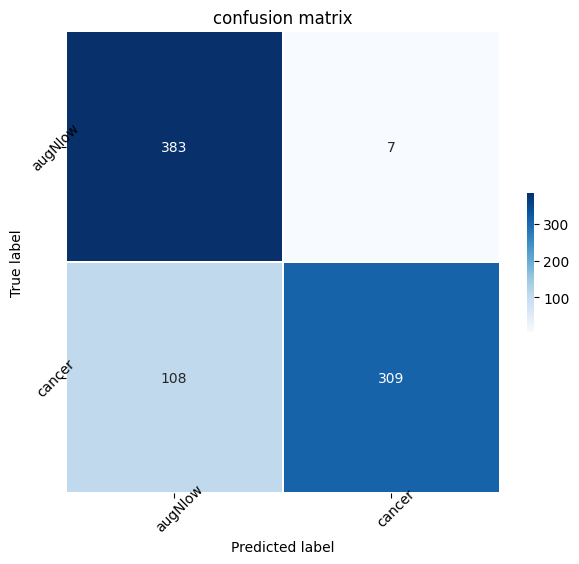

In [ ]:
# Confirm the result of finetuning
# Plot the confusion matrix

plot_confusion_matrix(model, x_test, LABEL_TO_CLASS)

In [ ]:
model.save_weights('/content/gdrive/MyDrive/weights/grad16.h5')

In [ ]:
model.load_weights('/content/gdrive/MyDrive/weights/grad16.h5')

In [ ]:
history = model.fit_generator(
    datagen_train.flow(
        x_train,
        y_train,
        batch_size=BATCH_SIZE,
    ),
    epochs=N_EPOCHS,
    validation_data=datagen_test.flow(
        x_test,
        y_test,
        batch_size=BATCH_SIZE,
    ),
)

Epoch 1/5
101/101 [==============================] - 22s 222ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.0587 - accuracy: 0.9817 - val_loss: 0.3011 - val_accuracy: 0.9182
Epoch 2/5
101/101 [==============================] - 20s 195ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.0424 - accuracy: 0.9839 - val_loss: 0.4507 - val_accuracy: 0.8897
Epoch 3/5
101/101 [==============================] - 21s 209ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.0384 - accuracy: 0.9851 - val_loss: 0.5330 - val_accuracy: 0.8885
Epoch 4/5
101/101 [==============================] - 20s 193ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.0384 - accuracy: 0.9857 - val_loss: 0.4435 - val_accuracy: 0.8897
Epoch 5/5
101/101 [==============================] - 21s 210ms/step - batch: 50.0000 - size: 31.9307 - loss: 0.0412 - accuracy: 0.9854 - val_loss: 0.4561 - val_accuracy: 0.8922


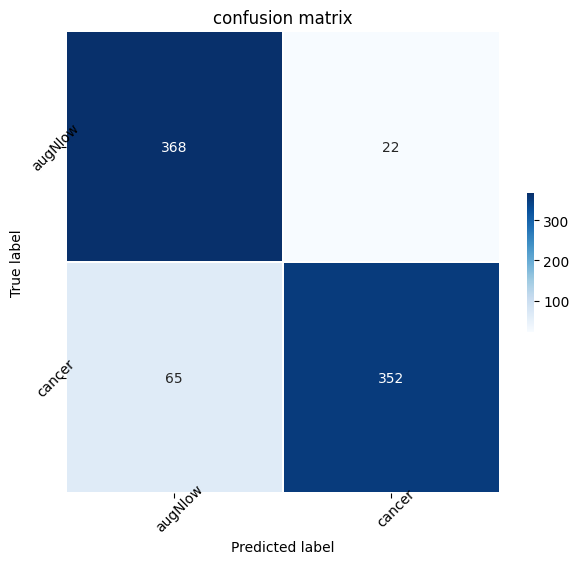

In [ ]:
# Confirm the result of finetuning
# Plot the confusion matrix

plot_confusion_matrix(model, x_test, LABEL_TO_CLASS)

In [ ]:
import tensorflow

In [ ]:
tensorflow.compat.v1.disable_eager_execution()


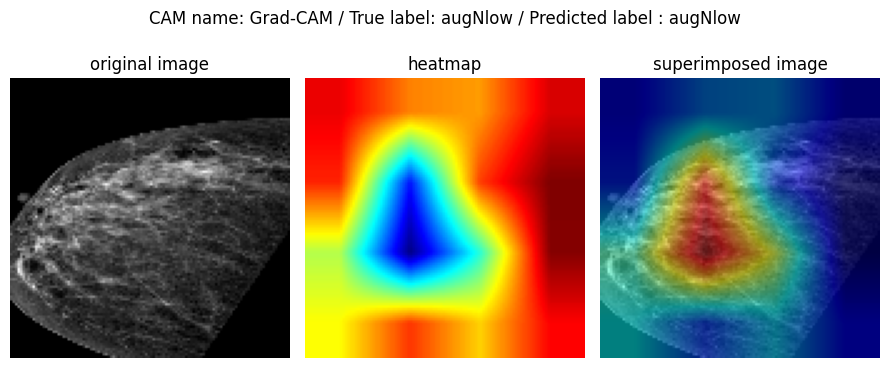

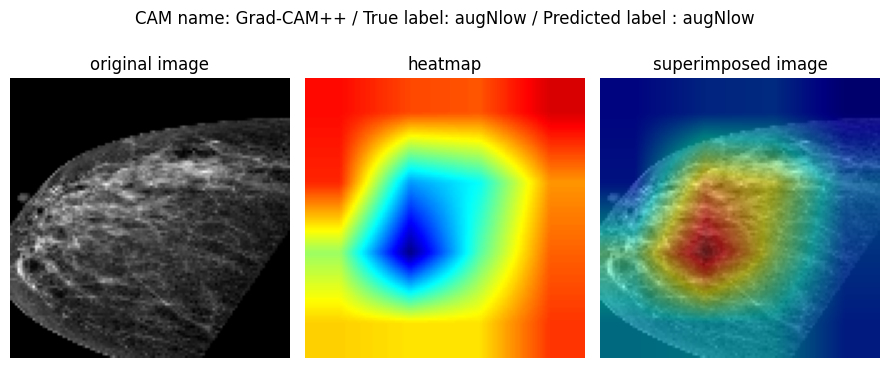

error: ignored

In [ ]:
plot_org_img_and_cam_heatmap(
    model=model,
    cam_func=grad_cam,
    superimpose=superimpose,
    img=images[0],
    cls_true=classes[0],
    class_to_label=CLASS_TO_LABEL,
    cam_name="Grad-CAM",
)
plot_org_img_and_cam_heatmap(
    model=model,
    cam_func=grad_cam_plus_plus,
    superimpose=superimpose,
    img=images[0],
    cls_true=classes[0],
    class_to_label=CLASS_TO_LABEL,
    cam_name="Grad-CAM++",
)
plot_org_img_and_cam_heatmap(
    model=model,
    cam_func=score_cam,
    superimpose=superimpose,
    img=images[0],
    cls_true=classes[0],
    class_to_label=CLASS_TO_LABEL,
    cam_name="Score-CAM",
)

<h2>(9) Compare with each cam</h2>

In [ ]:
for k, v in LABEL_TO_CLASS.items():
    compare_each_cam(
        images=images,
        classes=classes,
        class_to_label=CLASS_TO_LABEL,
        model=model,
        grad_cam=grad_cam,
        grad_cam_plus_plus=grad_cam_plus_plus,
        score_cam=score_cam,
        superimpose=superimpose,
        layer_name=model.layers[-2].name,
        target_cls=v,
    )

In [1]:
!pip freeze > requirements.txt
!python --version > py_ver.txt
!cat /proc/driver/nvidia/version > nvidia_ver.txt

'cat' is not recognized as an internal or external command,
operable program or batch file.
